In [1]:
from pyiron import Project
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%config InlineBackend.figure_format = 'retina'

In [2]:
pr = Project('interstitial')
fcc = pr.create.structure.bulk('Al', cubic=True).repeat((1,1,2))

# Create meshgrid

In [3]:
class FindInterstitials:
    def __init__(self, structure, n_gridpoints_by_layer=20, min_distance=1):
        self.n_gridpoints_by_layer = n_gridpoints_by_layer
        self.min_distance = min_distance
        self.structure = structure
        self._create_gridpoints()
        if min_distance > 0:
            self._remove_too_close()

    def _create_gridpoints(self):
        gridpoints = self.n_gridpoints_by_layer*(self.structure.analyse.get_layers().max(axis=0)+1)
        cell = self.structure.cell.diagonal()
        meshgrid = np.array([np.linspace(0, cell[i], gridpoints[i], endpoint=False) for i in range(3)])
        meshgrid = np.meshgrid(*meshgrid)
        meshgrid = np.stack(meshgrid, axis=-1).reshape(-1, 3)
        self.meshgrid = meshgrid
        
    def _remove_too_close(self):
        neigh = self.structure.get_neighborhood(self.meshgrid, num_neighbors=1)
        self.meshgrid = self.meshgrid[neigh.distances.flatten()>self.min_distance]
        
    def get_interstitials(self, num_neighbors=4, n_bins=100, interstitial_to_atom_ratio=10):
        self.interstitials = self.structure.get_neighborhood(self.meshgrid, num_neighbors=num_neighbors)
        deviation = self._get_variance()
        cutoff = self._get_cutoff(d=deviation, n_bins=n_bins, interstitial_to_atom_ratio=interstitial_to_atom_ratio)
        return self.meshgrid[deviation<cutoff]
    
    def _get_variance(self):
        return np.linalg.norm(np.sum(self.interstitials.vecs, axis=-2), axis=-1)
        
    def _get_cutoff(self, d, n_bins=100, interstitial_to_atom_ratio=10):
        count, position = np.histogram(d, bins=n_bins)
        mean_position = 0.5*(position[1:]+position[:-1])
        indices = np.cumsum(count)/len(self.structure) <= interstitial_to_atom_ratio
        indices[0] = True
        return mean_position[indices][-1]
    

In [4]:
bcc = pr.create.structure.bulk('Fe', cubic=True).repeat(2)

In [5]:
interstitials = FindInterstitials(bcc)

In [6]:
# volume of a sphere: v = 4*pi*r**3/3 -> r = (3*v/(4*pi))**(1/3)
r_char = (3*bcc.get_volume(per_atom=True)/(4*np.pi))**(1/3)

r_char

1.4131091063442693

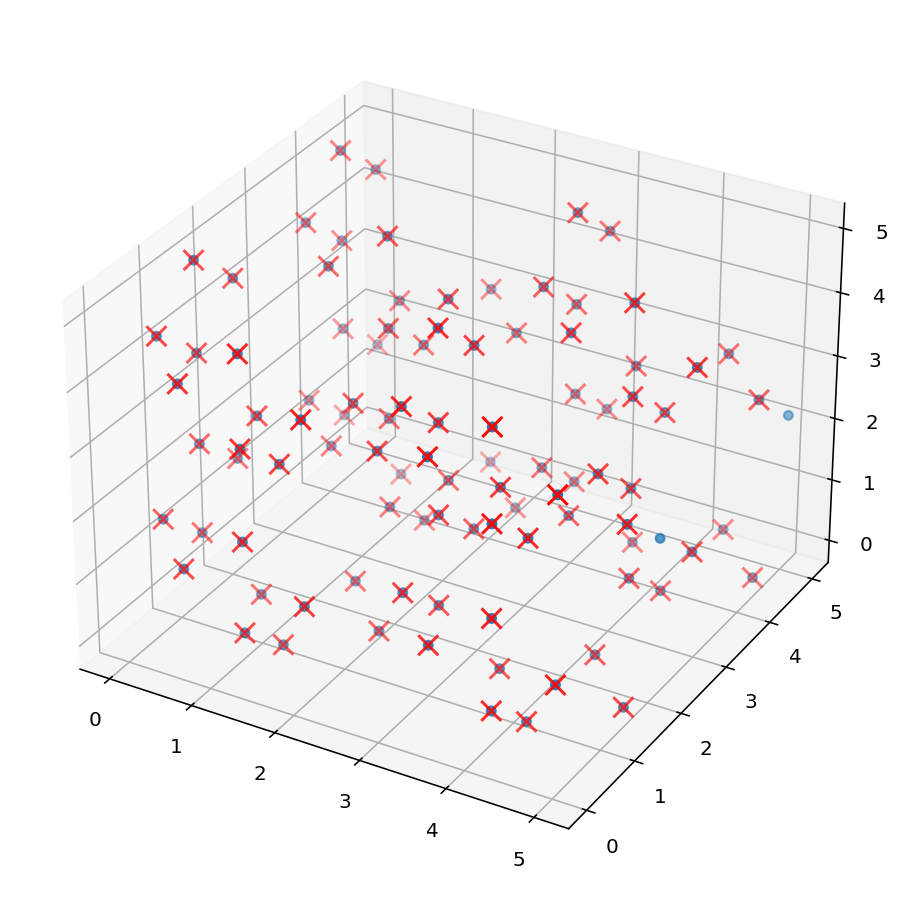

In [7]:
voro = bcc.analyse.get_voronoi_vertices()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
x = interstitials.get_interstitials()
ax.scatter3D(*x.T)
ax.scatter(*voro.T, c='red', marker='x', s=100)

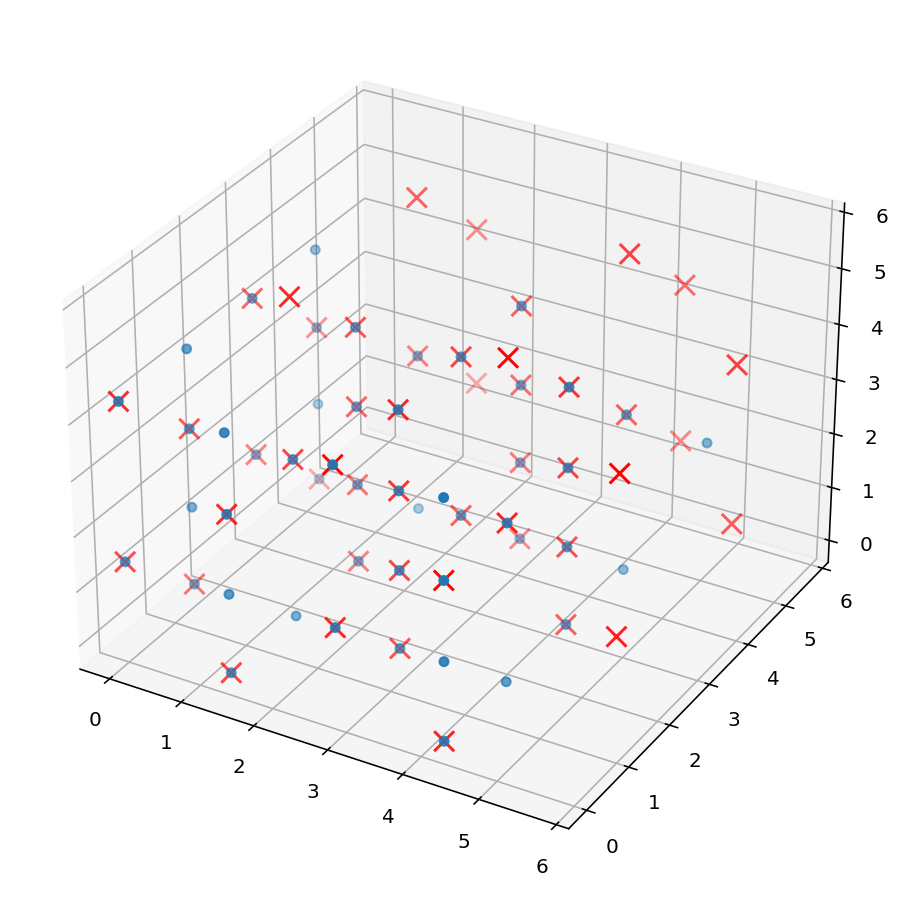

In [8]:
octa_positions = bcc.positions[:,None,:]+0.25*bcc.cell[None,:,:]
octa_positions = octa_positions.reshape(-1, 3)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
# condition = d < mean_position[np.cumsum(count)<10*n_atoms][-1]
x = interstitials.get_interstitials(num_neighbors=6)
ax.scatter3D(*x.T)
# ax.scatter3D(*meshgrid[condition].T, c=labels)
# ax.scatter(*bcc.positions.T, c='red')
ax.scatter(*octa_positions.T, c='red', marker='x', s=100)
# ax.scatter(*voro.T, c='red', marker='x', s=100)